In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
data_df = pd.read_csv('palm_ffb.csv')

In [13]:
col_features = data_df.columns.drop(['Date', 'FFB_Yield'])
col_target = 'FFB_Yield'

# EDA

## Univariate Analysis

In [14]:
data_df.describe()

,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,527.646923,26.849918,21.379231,33.851538,188.980769,24.753846,793404.491565,1.602231
std,57.367844,0.651413,0.688971,1.079638,80.237210,1.239289,34440.893854,0.281751
min,380.700000,25.158065,18.900000,31.100000,2.000000,21.000000,683431.944400,1.080000
25%,488.625000,26.442285,21.000000,33.100000,140.300000,24.000000,768966.949100,1.390000
50%,538.300000,26.930645,21.500000,33.900000,182.150000,25.000000,790036.158050,1.585000
75%,571.025000,27.270726,21.800000,34.600000,226.100000,26.000000,821989.235250,1.807500
max,647.300000,28.580000,22.600000,36.000000,496.100000,27.000000,882254.225400,2.270000


<Figure size 800x800 with 0 Axes>

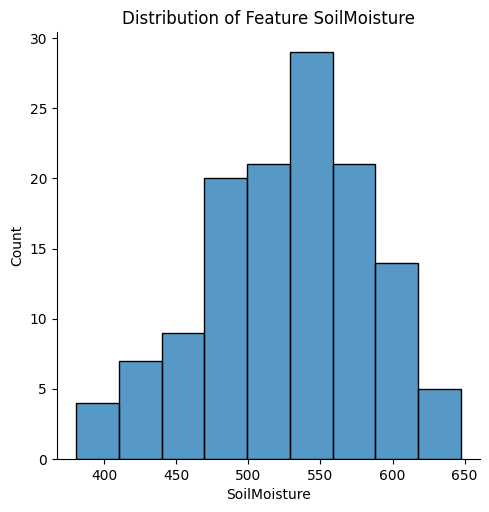

<Figure size 800x800 with 0 Axes>

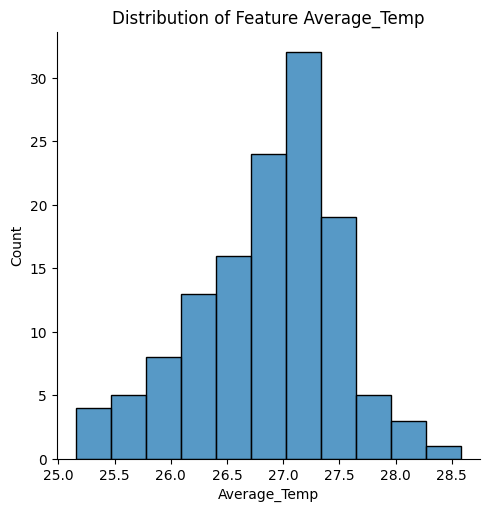

<Figure size 800x800 with 0 Axes>

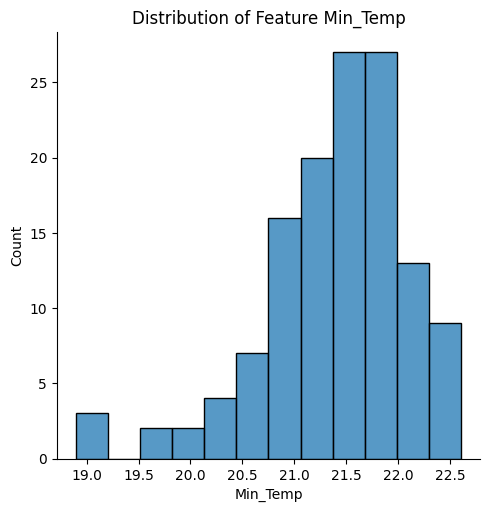

<Figure size 800x800 with 0 Axes>

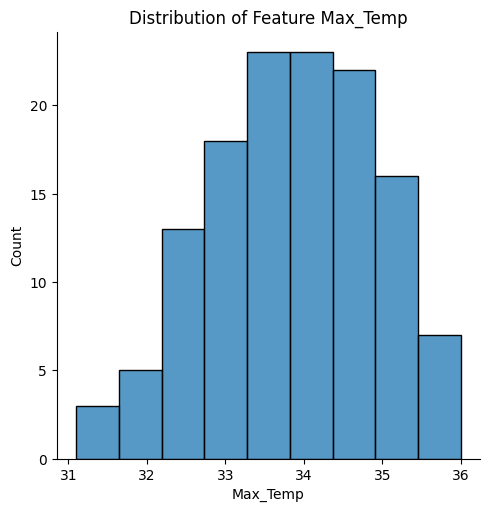

<Figure size 800x800 with 0 Axes>

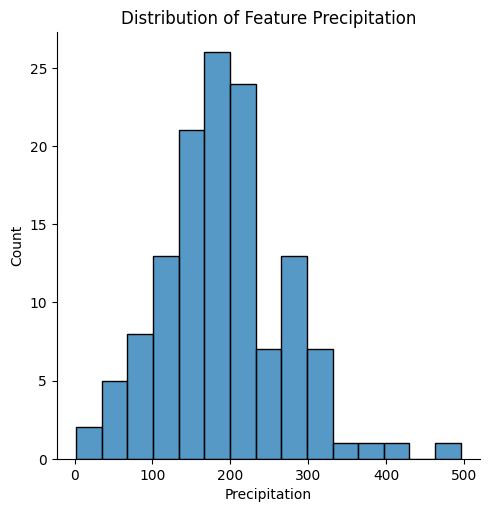

<Figure size 800x800 with 0 Axes>

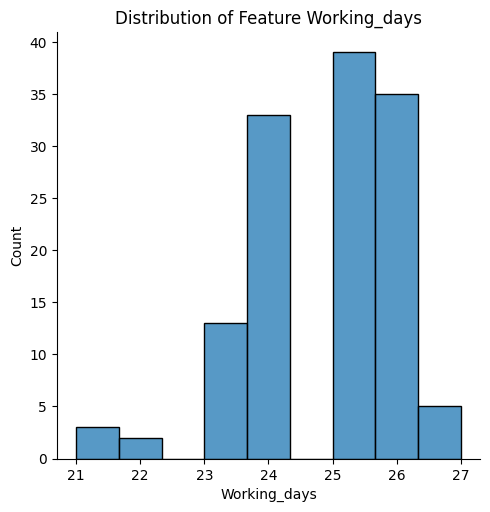

<Figure size 800x800 with 0 Axes>

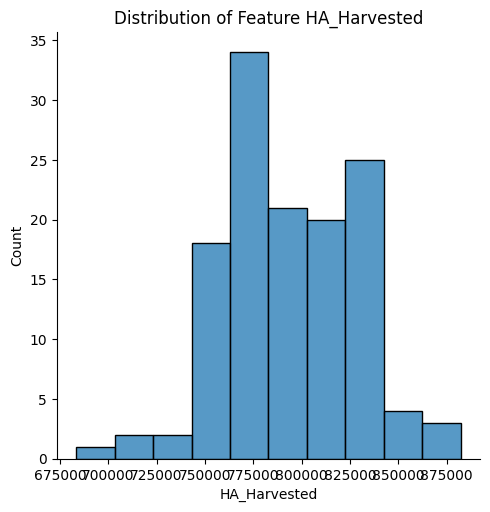

In [15]:
for col in col_features:
    plt.figure(figsize=(8,8))
    sns.displot(data_df[col], kind='hist')
    plt.title(f'Distribution of Feature {col}')

Text(0.5, 1.0, 'Distribution of Target Variable FFB_Yield')

<Figure size 800x800 with 0 Axes>

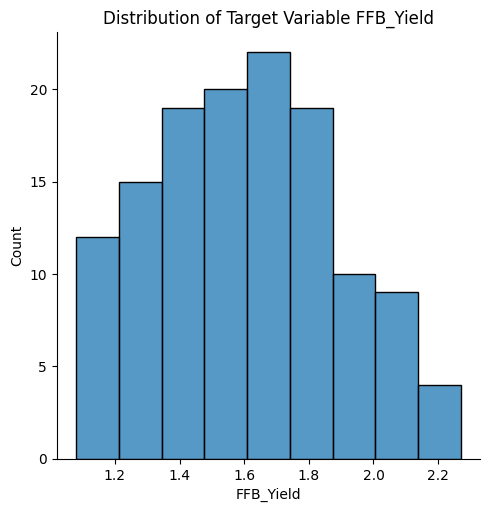

In [16]:
plt.figure(figsize=(8,8))
sns.displot(data_df[col_target], kind='hist')
plt.title(f'Distribution of Target Variable {col_target}')

- All features have normal-like distribution with very light skewness, not enough to warrant a power transform to correct the skewness

# Multivariate Analysis

### 1. Feature Cross-correlation

Text(0.5, 1.0, 'Cross-Correlation between features')

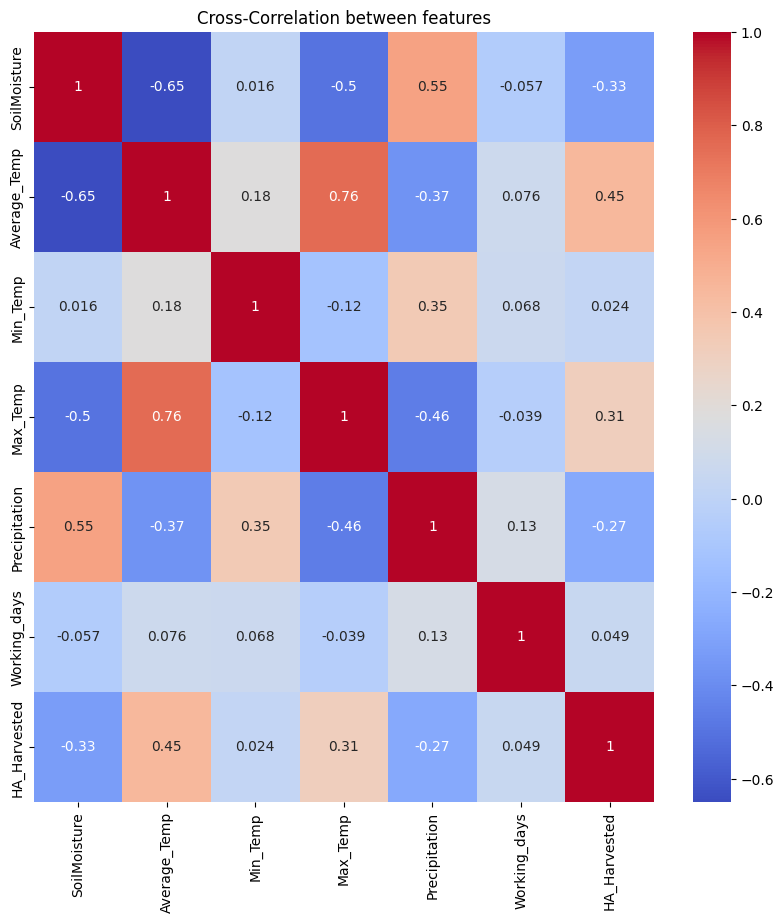

In [20]:
plt.figure(figsize=(10,10))
sns.heatmap(data_df[col_features].corr(), cmap='coolwarm', annot=True)
plt.title('Cross-Correlation between features')

- There is a high degree of correlation between soil mixture, average temp, min_temp, max_temp, and precipitation. This may may reduce the accuracy of the estimates of regression coefficients (collinearity). If interpretation is more important than prediction accuracy in this case, we might want to consider dropping one or more of the variables

### 2. Correlation between target variable and features

In [22]:
data_df.corr()[col_target]

SoilMoisture    -0.003183
Average_Temp    -0.005494
Min_Temp         0.103830
Max_Temp        -0.071201
Precipitation    0.289604
Working_days     0.116364
HA_Harvested    -0.350222
FFB_Yield        1.000000
Name: FFB_Yield, dtype: float64

- Most of the features show weak correlation to FFB_Yield, which may be detrimental to the prediction accuracy of the regression
- The most promising features are precipitation, working days and HA_Harvested with correlation of 0.29, 0.12, -0.35 respectively

### 3. Are there any clear differences between the distributions of high FFB_Yields and low/average FFB_Yields?

<Figure size 800x800 with 0 Axes>

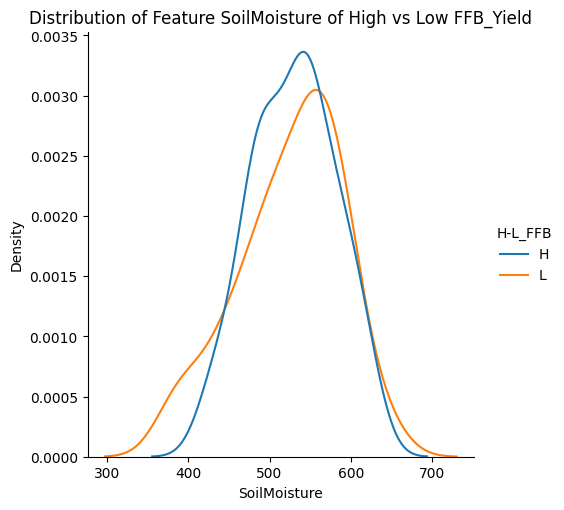

<Figure size 800x800 with 0 Axes>

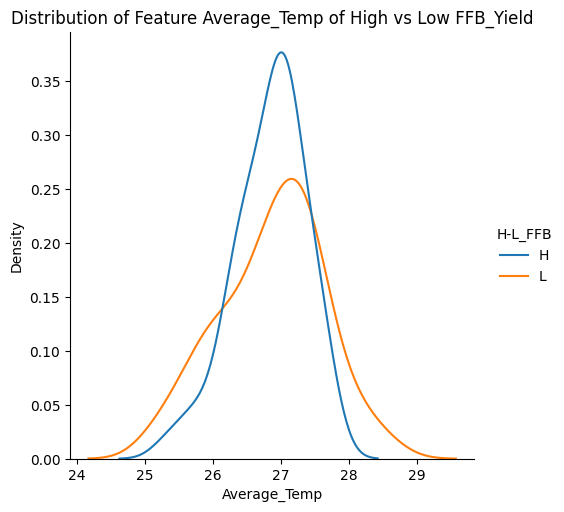

<Figure size 800x800 with 0 Axes>

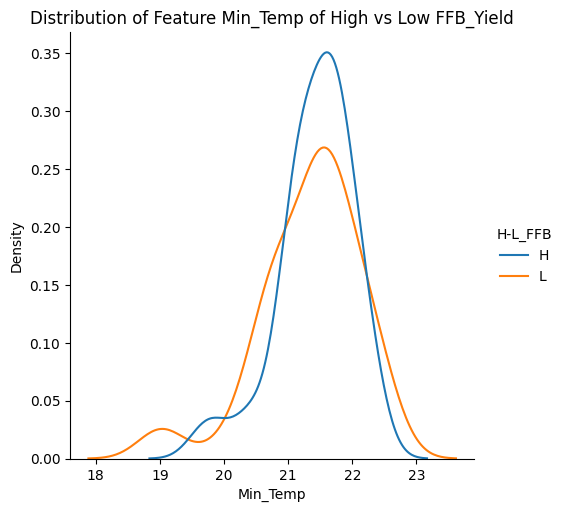

<Figure size 800x800 with 0 Axes>

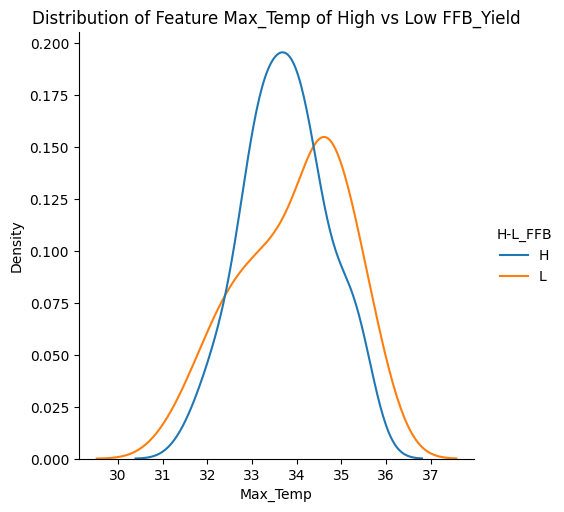

<Figure size 800x800 with 0 Axes>

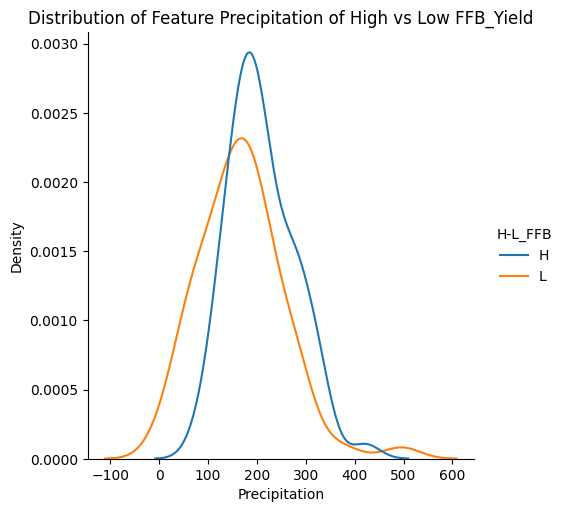

<Figure size 800x800 with 0 Axes>

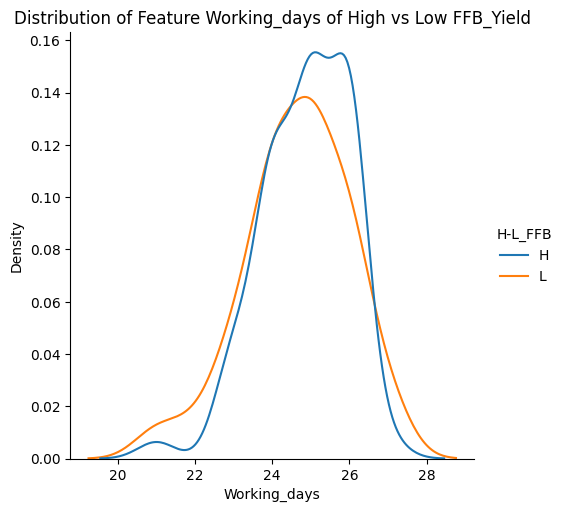

<Figure size 800x800 with 0 Axes>

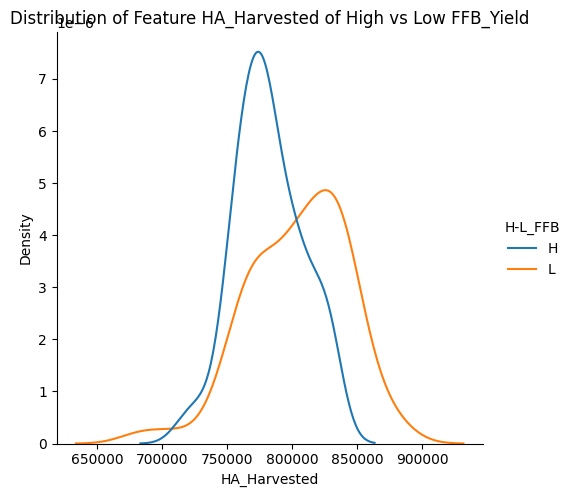

In [27]:
# Label above 50% quantile as high FFB_Yields and below as low FFB_Yields
df_HL = data_df.copy()
df_HL['H-L_FFB'] = ['H' if i > df_HL[col_target].quantile(0.5) else 'L' for i in df_HL[col_target]]


for col in col_features:
    plt.figure(figsize=(8,8))
    sns.displot(data=df_HL, x=col, kind='kde', hue='H-L_FFB')
    plt.title(f'Distribution of Feature {col} of High vs Low FFB_Yield')

- In line with the correlation analysis, there are slight difference between the distribution in 3 features: precipitation, working days (positive relation) and HA_Harvested (negative relation)

# Regression Analysis

### Simple Linear Regression

As the focus here is to determine the important features for FFB_Yield, no splitting on training and testing sets needed

In [36]:
# from sklearn.model_selection import train_test_split



X = data_df[col_features]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X, columns=col_features)

y = data_df[col_target]
# X_train, y_train, X_test, y_test = train_test_split(X, y, random_state=100, test_size=0.2)

In [37]:
import statsmodels.api as sm

X_scaled = sm.add_constant(X_scaled)
ols = sm.OLS(y, X_scaled).fit()

predictions = ols.predict(X_scaled) 

summary = ols.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:              FFB_Yield   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     5.935
Date:                Sat, 20 Aug 2022   Prob (F-statistic):           5.92e-06
Time:                        18:02:36   Log-Likelihood:               -0.23443
No. Observations:                 130   AIC:                             16.47
Df Residuals:                     122   BIC:                             39.41
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.7331      1.520      1.798

- Only Precipitation and HA_Harvested has statistically significant effect on FFB_Yield (p_value < 0.05), but at a very small magnitude 
- The adjusted R2 value of the fit is terrible at 0.211 i.e. the model is only able to account for 21% of the variance.
- As indicted by the statsmodel packs, there is a strong multicollinearity issue with the data. Some features should be dropped to improve the accuracy of the regression coefficients


In [43]:
# Dropping Average Temp as it is correlated with SoilMoisture

col_features = data_df.columns.drop(['Date', 'FFB_Yield', 'Average_Temp'])

X = data_df[col_features]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X, columns=col_features)

y = data_df[col_target]


In [44]:
import statsmodels.api as sm

X_scaled = sm.add_constant(X_scaled)
ols = sm.OLS(y, X_scaled).fit()

predictions = ols.predict(X_scaled) 

summary = ols.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:              FFB_Yield   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     6.606
Date:                Sat, 20 Aug 2022   Prob (F-statistic):           4.50e-06
Time:                        18:17:54   Log-Likelihood:                -1.1281
No. Observations:                 130   AIC:                             16.26
Df Residuals:                     123   BIC:                             36.33
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5141      1.400      2.510

In [ ]:
(0.0014 * data_df['SoilMoisture'].std()) + data_df['HA_Harvested'].mean()

- Dropping 'Average_Temp' improved the p-value of SoilMoisture significantly. The coefficient p-value for SoilMoisture is now 0.006 (< 0.05).

### Interaction Terms

Now, we explore whether an interaction between any pair of the feature contribute to the prediction of the target variable.
We only use the features that have a statistically significant coefficient in the simple linear regression

In [61]:
col_features = ['SoilMoisture', 'Precipitation', 'HA_Harvested']
data_df_interact = data_df.copy()

from itertools import combinations

col_interact_list = []
for interact_tup in combinations(col_features, 2):
    col_interact = '_'.join(interact_tup)
    col_interact_list.append(col_interact)
    col_1, col_2 = interact_tup
    data_df_interact[col_interact] = data_df_interact[col_1] * data_df_interact[col_2]
col_interact_list

['SoilMoisture_Precipitation',
 'SoilMoisture_HA_Harvested',
 'Precipitation_HA_Harvested']

In [62]:
X = data_df_interact[list(col_features) + list(col_interact_list)]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X, columns=list(col_features) + list(col_interact_list))

y = data_df_interact[col_target]

X_scaled = sm.add_constant(X_scaled)
ols = sm.OLS(y, X_scaled).fit()

predictions = ols.predict(X_scaled) 

summary = ols.summary()
print(summary)



                            OLS Regression Results                            
Dep. Variable:              FFB_Yield   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     9.533
Date:                Sat, 20 Aug 2022   Prob (F-statistic):           1.35e-08
Time:                        18:42:12   Log-Likelihood:                 5.5374
No. Observations:                 130   AIC:                             2.925
Df Residuals:                     123   BIC:                             23.00
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

- From this, we can see that the interaction of SoilMoisture * Precipitation is the real contributor to FFB_Yield, yielding the lowest p-value in the regression above, better than each feature individualy
- Now, The statistically significant variables are Precipitation, SoilMoisture_Precipitation, and maybe HA_Harvested

Final rerun of the regression with appropriate terms

In [65]:
X = data_df_interact[['Precipitation', 'SoilMoisture_Precipitation', 'HA_Harvested']]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X, columns=['Precipitation', 'SoilMoisture_Precipitation', 'HA_Harvested'])

y = data_df_interact[col_target]

X_scaled = sm.add_constant(X_scaled)
ols = sm.OLS(y, X_scaled).fit()

predictions = ols.predict(X_scaled) 

summary = ols.summary()
print(summary)


                            OLS Regression Results                            
Dep. Variable:              FFB_Yield   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     17.78
Date:                Sat, 20 Aug 2022   Prob (F-statistic):           1.09e-09
Time:                        18:49:20   Log-Likelihood:                 3.6650
No. Observations:                 130   AIC:                            0.6701
Df Residuals:                     126   BIC:                             12.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

This yields an adjusted R-squared of 0.281, which is as good as it gets with minimal features that matter, in a linear regression setting

In [66]:
data_df_interact['Precipitation'].std()

80.23721042875427

In [67]:
data_df_interact['HA_Harvested'].std()

34440.89385420054

In [68]:
data_df_interact['SoilMoisture_Precipitation'].std()

51524.02484550039

- Conclusion: The features Precipitation, HA_Harvested and (SoilMoisture times Precipitation) are the only statistically significant features that have an effect on FFB_Yield:
- Every increase of 80.2 unit of Precipitation leads to 0.0079 increase in FFB_Yield
- Every decrease of 34440 unit of HA_Harvested leads to 1.137e-05 increase in FFB_Yield, which is rather negligible
- Every decrease of 51524 unit of (SoilMoisture * Precipitation) leads to 3.054e-06 increase in FFB_Yield, which is rather negligible
- The data given is definitely not enough to discern the main contributing factors to FFB_Yield

# Striving for the highest prediction accuracy

In this section, we will attempt to find the best model to predict FFB_Yield, optimising for prediction accuracy, using mainly non-parametric model:
1. Ridge regression (as baseline)
2. SVM
3. DecisionTree
4. RandomForest
5. XGBoost

In [75]:
data_df[col_target]

0      1.62
1      1.45
2      1.56
3      1.39
4      1.44
       ... 
125    1.29
126    1.42
127    1.61
128    1.91
129    2.04
Name: FFB_Yield, Length: 130, dtype: float64

In [76]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

col_features = data_df.columns.drop(['Date', 'FFB_Yield'])
X = data_df[col_features]
y = data_df[col_target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X, columns=col_features)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=100, test_size=0.2)

models_name = ['Ridge', 'SVR', 'DecisionTree', 'RF', 'XGB']
models = [Ridge(),
          SVR(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          XGBRegressor()
          ]

for model_name, model in zip(models_name, models):
    cross_val = KFold(5)
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=cross_val, n_jobs=-1)
    print(f'{model_name} CV RMSE: {-1 * scores.mean()}')


Ridge CV RMSE: 0.2639101653650443
SVR CV RMSE: 0.2623136326393764
DecisionTree CV RMSE: 0.34084296499993794
RF CV RMSE: 0.23216098095266116
XGB CV RMSE: 0.23408042575504107


- Decision Tree showed the best cross-validation results with 0.341 RMSE

Hyperparameter optimisation (not extensive):

In [78]:
from hyperopt import hp, tpe, Trials, STATUS_OK, fmin

# Define the search space
space = {
    'criterion': hp.choice('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    'min_samples_split': hp.choice('min_samples_split', [2, 3, 5]),
    'max_features': hp.choice('max_features', ['sqrt', None, 'auto', 'log2']),
    }

def bayes_objective(params):
    global ITERATION
    ITERATION += 1
    cross_val = KFold(5)
    scores = cross_val_score(
        DecisionTreeRegressor(
            criterion=params['criterion'],
            min_samples_split=params['min_samples_split'],
            max_features=params['max_features']
            ),
        X_train, y_train, scoring='neg_root_mean_squared_error', cv=cross_val, n_jobs=-1)
    loss = scores.mean()
    print(f"Optimization Iteration {ITERATION}, mean score = {scores.mean()}")
    return {'loss': loss, 'params': params, 'iteration': ITERATION, 'status': STATUS_OK}
    
tpe_algorithm = tpe.suggest
bayes_trials = Trials()

# Run optimization
global ITERATION
ITERATION = 0
max_evals = 10
bayes_output = fmin(fn = bayes_objective, space = space, algo = tpe.suggest, max_evals = max_evals, trials = bayes_trials, rstate = np.random.default_rng(100))

bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])
best_bayes_output = bayes_trials_results[0]
best_bayes_output

Optimization Iteration 1, mean score = -0.2849297180557616
Optimization Iteration 2, mean score = -0.32976346499184644                      
Optimization Iteration 3, mean score = -0.3191494795742167                        
Optimization Iteration 4, mean score = -0.31448776815305096                       
Optimization Iteration 5, mean score = -0.2880585510581438                        
Optimization Iteration 6, mean score = -0.3175258984216307                        
Optimization Iteration 7, mean score = -0.3337617674156381                        
Optimization Iteration 8, mean score = -0.34311288799872547                       
Optimization Iteration 9, mean score = -0.3093107112330606                       
Optimization Iteration 10, mean score = -0.3199035590445173                       
100%|██████████| 10/10 [00:02<00:00,  3.56trial/s, best loss: -0.34311288799872547]


{'loss': -0.34311288799872547,
 'params': {'criterion': 'squared_error',
  'max_features': None,
  'min_samples_split': 3},
 'iteration': 8,
 'status': 'ok'}

Hyperparameter optimisation did not improve the model performance by much

In [80]:
# Testing accuracy

best_params = best_bayes_output['params']
rf_best = DecisionTreeRegressor(
    criterion=best_params['criterion'],
    min_samples_split=best_params['min_samples_split'],
    max_features=best_params['max_features']
)
rf_best.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = rf_best.predict(X_test)
print(f'Best model Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

y_pred_train = rf_best.predict(X_train)
print(f'Best model Training RMSE : {np.sqrt(mean_squared_error(y_train, y_pred_train))}')


print('\n')
print(f'Best model Testing MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Best model Training MAE : {mean_absolute_error(y_train, y_pred_train)}')


Best model Testing RMSE: 0.40445594986922295
Best model Training RMSE : 0.034786436348757464


Best model Testing MAE: 0.32499999999999996
Best model Training MAE : 0.017596153846153855


In [81]:
data_df.describe()[col_target]

count    130.000000
mean       1.602231
std        0.281751
min        1.080000
25%        1.390000
50%        1.585000
75%        1.807500
max        2.270000
Name: FFB_Yield, dtype: float64

- The model is massively overfitted, with a training RMSE of 0.0347 but a testing RMSE of 0.404 (more than 10 times difference).
- An RMSE error of 0.4 is not acceptable for any prediction considering that the standard deviation of the target variable is 0.28